# Import Libraries

In [3]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score

import json

# Create Data Class

In [4]:
class Category:
    ELECTRONICS = "ELECTRONICS"
    BOOKS = "BOOKS"
    CLOTHING = "CLOTHING"
    GROCERY = "GROCERY"
    PATIO = "PATIO"
    
class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"

class Review:
    def __init__(self, category, text, score):
        self.category = category
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: # Amazon review is a 4 or 5
            return Sentiment.POSITIVE
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
    
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_x(self, vectorizer):
        return vectorizer.transform(self.get_text())
    
    def get_y(self):
        return [x.sentiment for x in self.reviews]
    
    def get_category(self):
        return [x.category for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        print(len(positive_shrunk))
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        print(self.reviews[0])
        

# Load Data 

In [5]:
file_names = [r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\data\Books_small.json',
              r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\data\Clothing_small.json',
              r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\data\Electronics_small.json',
              r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\data\Grocery_small.json',
              r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\data\Patio_small.json']

file_categories = [Category.BOOKS, Category.CLOTHING, Category.ELECTRONICS, Category.GROCERY, Category.PATIO]

reviews = []
for file_name, category in zip(file_names, file_categories):
    with open(file_name) as f:
        for line in f:
            review_json = json.loads(line)
            review = Review(category, review_json['reviewText'], review_json['overall'])
            reviews.append(review)

# Prepare Data

In [6]:
train, test = train_test_split(reviews, test_size = 0.33, random_state = 42)

train_container = ReviewContainer(train)
test_container = ReviewContainer(test)

In [7]:
train, test = train_test_split(reviews, test_size = 0.33, random_state=42)

train_container = ReviewContainer(train)
test_container = ReviewContainer(test)

corpus = train_container.get_text()
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

train_x = train_container.get_x(vectorizer)
train_y = train_container.get_category()

test_x = test_container.get_x(vectorizer)
test_y = test_container.get_category()

## Bag of words vectorization

### Classifications

#### Linear SVM

In [9]:
from sklearn import svm

clf = svm.SVC(C=16, kernel='linear', gamma='auto')
clf.fit(train_x, train_y)

test_set = ['great for my wedding', "loved it in my garden", 'good computer']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['ELECTRONICS', 'PATIO', 'ELECTRONICS'], dtype='<U11')

#### Naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# print(train_x)
gnb.fit(np.asarray(train_x.todense()), train_y)
accuracy = gnb.score(np.asarray(test_x.todense()), test_y)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8109090909090909


### Evaluation

In [12]:
y_pred = clf.predict(test_x)

f1_score(test_y, y_pred, average=None)

clf.score(test_x, test_y)

0.9084848484848485

### Model Tuning

In [13]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,8,16,32]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x, train_y)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'kernel': ('linear', ...)}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [14]:
clf.score(test_x, test_y)

0.916969696969697

### Saving Model

#### Save Model

In [23]:
import pickle

# Save classifier
with open(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\models\category_classifier.pkl','wb') as f:
    pickle.dump(clf, f)

# Save vectorizer in a separate file
with open(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\models\vectorizer.pkl','wb') as f:
    pickle.dump(vectorizer, f)


#### Load Model

In [25]:
with open(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\models\category_classifier.pkl','rb') as f:
    clf = pickle.load(f)

# Load vectorizer
with open(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Amazon Reviews\models\vectorizer.pkl','rb') as f:
    vectorizer = pickle.load(f)

In [27]:
test_set = ['very quick speeds', "loved the necklace", 'bad']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['BOOKS', 'CLOTHING', 'GROCERY'], dtype='<U11')

#### Confusion Matrix

<Axes: >

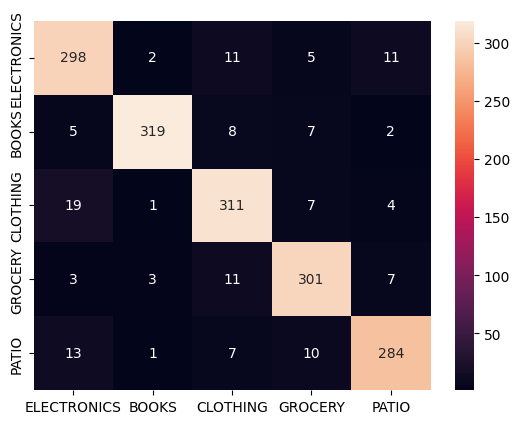

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(test_x)

labels = [Category.ELECTRONICS, Category.BOOKS, Category.CLOTHING, Category.GROCERY, Category.PATIO]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')